In [162]:
# Import Keras and other Deep Learning dependencies
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense, Dropout
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import *
from keras.engine.topology import Layer
from keras.regularizers import l2
import cv2
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
from tqdm import tqdm_notebook
from sklearn.metrics import accuracy_score
from sklearn import metrics
from collections import Counter 

In [39]:
def initialize_weights(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

def get_siamese_model(input_shape, similarity_metric='l1'):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape,
                    kernel_initializer=initialize_weights, 
                    kernel_regularizer=l2(2e-4)))
    
    model.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape,
                    kernel_initializer=initialize_weights, 
                    kernel_regularizer=l2(2e-4)))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.25))
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(input_shape[0]**2, activation='sigmoid', kernel_initializer=initialize_weights,
                    bias_initializer=initialize_bias, 
                    kernel_regularizer=l2(1e-3),))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    if similarity_metric == 'l1':
        Similarity_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))        
    elif siamese_metric == 'l2':
        Similarity_layer = Lambda(lambda tensors:K.sqrt(K.square(tensors[0] - tensors[1])))
    elif siamese_metric == 'cross': ## TODO
        Similarity_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))     
        
    Similarity_distance = Similarity_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(Similarity_distance)
    
    # Connect the input with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    model.summary()
    return siamese_net

In [40]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [239]:
class Siamese_Loader:
    def __init__(self, train_path, 
                 test_path=None, dataset_type = '49kmnist'):
        """
        Loads dataset
        
        Parameters
        -----------
        
        train_path ... list[train_images, train_labels]
        test_path ... list[test_images, test_labels]
        
        """
        self.train_images = []
        self.train_labels = []
        self.train_path = train_path
        
        self.test_images = []
        self.test_labels = []        
        self.test_path = test_path
        
        self.dataset_type = dataset_type        
        
        print('Loading Train images')
        self.train_images = self._load(self.train_path[0])
        
        print('Loading Test images')
        self.test_images = self._load(self.test_path[0])
        
        print('Loading Train labels')
        self.train_labels = self._load(self.train_path[1])
        
        print('Loading Test labels')
        self.test_labels = self._load(self.test_path[1])
        
        self.train_n_classes = len(np.unique(self.train_labels))
        self.test_n_classes = len(np.unique(self.test_labels))
        
    def _load(f):
        return np.load(f)['arr_0']
        
    def _get_index(self, labels, i, images):
        while True:
            idx = np.random.randint(0, len(images))
            if labels[idx] == i:
                return idx, labels[idx]
            
    def _get_false_index(self, labels, i, images):
        while True:
            idx = np.random.randint(0, len(images))
            if labels[idx] != i:
                return idx, labels[idx]
            
    def get_batch(self, batch_multiplier = 1):
        n_examples = batch_multiplier*self.train_n_classes
        
        img_shape = self.train_images[0].shape
        pairs = [np.zeros((n_examples, img_shape[0], img_shape[1], 1)) for i in range(2)]
        targets = []
        k = 0
        
        for i in range(0, n_examples):
            img_1 = None
            img_2 = None
            
            if i%2 == 0:
                i_correto = i % n_examples
                idx_1, categ_1 = self._get_index(labels, i_correto, images)
                img_1 = self.train_images[idx_1]
                img_1 /= 255
                idx_2, categ_2 = self._get_index(labels, i_correto, images)
                img_2 = images[idx_2]
                img_1 /= 255
                target = 1
                
            else:
                idx_1, categ_1 = self._get_index(labels, i_correto, images)
                img_1 = self.train_images[idx_1]
                img_1 /= 255
                idx_2, categ_2 = self._get_false_index(labels, i_correto, images)
                img_2 = images[idx_2]
                img_1 /= 255 
                target = 0

            
            pairs[0][k] = img_1.reshape((28,28,1))
            pairs[1][k] = img_2.reshape((28,28,1))
            targets.append(target)
            k += 1
        
        return pairs, targets
                    
        
    def one_shot_task(self, N = 49, tipo = 'train'):
        """
        Create a set of pairs, targets for N-way one shot learning.
        """
        if tipo == 'train':
            images = self.train_images
            labels = self.train_labels
            n_classes = self.train_n_classes
        else:
            images = self.test_images
            labels = self.test_labels
            n_classes = self.test_n_classes
            
        
        img_shape = images[0].shape
        pairs = [np.zeros((N**2, img_shape[0], img_shape[1], 1)) for i in range(2)]
        targets = []
        k = 0
        
        for i in range(0, N):
            idx_base, categ_base = self._get_index(labels, i, images)
            img_base = images[idx_base]
            img_base /= 255
            
            img_pair = None
            for j in range(0, N):
                
                idx_pair, categ_pair = self._get_index(labels, j, images)
                img_pair = images[idx_pair]
                img_pair /= 255
                
                if categ_base == categ_pair:
                    targets.append(0)
                else:
                    targets.append(1)
                    
                pairs[0][k] = img_base.reshape((28,28,1))
                pairs[1][k] = img_pair.reshape((28,28,1))
                
                k += 1
        
        return pairs, targets
    
    def test_oneshot(self, model, N, k, verbose=True):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
        for i in range(k):
            inputs, targets = self.one_shot_task(N)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
        return percent_correct

In [167]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(ref, comparativas):
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(ref.reshape(28,28), cmap='gray')
    img = concat_images(comparativas)
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [122]:
# batch_size = 128
# num_classes = 10
# epochs = 12

In [240]:
# def load(f):
#     return np.load(f)['arr_0']

In [125]:
# Load the data
# x_train = load('dataset/kuzushiji-mnist/k49-train-imgs.npz')
# x_test = load('dataset/kuzushiji-mnist/k49-test-imgs.npz')
# y_train = load('dataset/kuzushiji-mnist/k49-train-labels.npz')
# y_test = load('dataset/kuzushiji-mnist/k49-test-labels.npz')

In [126]:
# ys = list()
# for y in y_train:
#     if y not in ys:
#         ys.append(y)
# print('N classes: {}'.format(len(ys)))
# print(len(Counter(y_train).keys()))
# np.unique(y_train, return_counts=True)

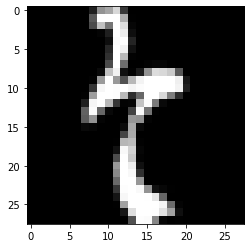

In [163]:
w = x_train[99]

plt.imshow(w, cmap="gray")

plt.show()

## Loading dataset

In [238]:
model = get_siamese_model((28, 28, 1))
model.compile(loss=contrastive_loss,optimizer=Adam(lr = 0.00006))
# model.compile(loss=contrastive_loss,optimizer=Adadelta())
# model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
__________

In [185]:
loader = Siamese_Loader(train_path=['dataset/kuzushiji-mnist/k49-train-imgs.npz',
                                    'dataset/kuzushiji-mnist/k49-train-labels.npz'],
                       test_path=['dataset/kuzushiji-mnist/k49-test-imgs.npz',
                                  'dataset/kuzushiji-mnist/k49-test-labels.npz'])

Loading Train images
Loading Test images
Loading Train labels
Loading Test labels


In [186]:
len(loader.train_images)

232365

In [205]:
N = 10

In [206]:
train_pairs, train_targets = loader.one_shot_task(N = N)

In [207]:
test_pairs, test_targets = loader.one_shot_task(N=N, tipo='test')

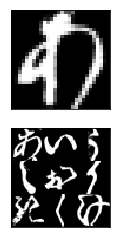

In [208]:
plot_oneshot_task(train_pairs[0][0], train_pairs[1][:N-1])

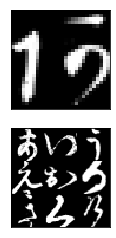

In [209]:
plot_oneshot_task(test_pairs[0][0], test_pairs[1][:N-1])

In [224]:
model.fit(x=train_pairs, y=train_targets, epochs=20) 

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.329 - ETA: 0s - loss: 0.331 - ETA: 0s - loss: 0.327 - 1s 5ms/step - loss: 0.3279
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.316 - ETA: 0s - loss: 0.324 - ETA: 0s - loss: 0.324 - 1s 5ms/step - loss: 0.3249
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.328 - ETA: 0s - loss: 0.325 - ETA: 0s - loss: 0.321 - 1s 6ms/step - loss: 0.3215
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.318 - ETA: 0s - loss: 0.317 - ETA: 0s - loss: 0.314 - 1s 6ms/step - loss: 0.3148
Epoch 5/20
100/100 [==============================] - ETA: 0s - loss: 0.308 - ETA: 0s - loss: 0.299 - ETA: 0s - loss: 0.296 - 1s 5ms/step - loss: 0.2959
Epoch 6/20
100/100 [==============================] - ETA: 0s - loss: 0.266 - ETA: 0s - loss: 0.261 - ETA: 0s - loss: 0.246 - 1s 5ms/step - loss: 0.2434
Epoch 7/20
100/100 [==============================] - ETA: 0s - loss: 0.152 - ETA:

KeyboardInterrupt: 

In [215]:
weight_path_fit = 'kmodel_weights/model_weights_2_10.h5'
model.save_weights(weight_path_fit)

In [225]:
predict = model.predict(x=test_pairs)

In [226]:
predict

array([[0.32257497],
       [0.40596676],
       [0.04879844],
       [0.19735923],
       [0.54889923],
       [0.32593703],
       [0.04822558],
       [0.37093085],
       [0.14562574],
       [0.10381502],
       [0.33838287],
       [0.5416107 ],
       [0.13991931],
       [0.34168398],
       [0.36664367],
       [0.31149876],
       [0.16439703],
       [0.15238464],
       [0.12630099],
       [0.37345016],
       [0.02106497],
       [0.40955853],
       [0.46842432],
       [0.27000862],
       [0.05254811],
       [0.0387623 ],
       [0.11478838],
       [0.53722   ],
       [0.01586536],
       [0.5339931 ],
       [0.22654065],
       [0.02255023],
       [0.30719146],
       [0.27875382],
       [0.00644752],
       [0.07783818],
       [0.5160066 ],
       [0.5322833 ],
       [0.06497964],
       [0.22605473],
       [0.13777211],
       [0.48394182],
       [0.00560188],
       [0.0087654 ],
       [0.33858246],
       [0.03756285],
       [0.24760237],
       [0.008

In [227]:
predict = model.predict(x=test_pairs)

In [228]:
fpr, tpr, thresholds = metrics.roc_curve(test_targets, predict)
metrics.auc(fpr, tpr)

0.39